In [4]:
import sys; sys.path.append("../")

from vle.utils import instantiate_from_config, load_config

from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionPipeline

from torchmetrics import StructuralSimilarityIndexMeasure
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
model = "CompVis/stable-diffusion-v1-4"
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
pipe = StableDiffusionPipeline.from_pretrained(model, vae=vae)
stability_model = pipe.vae.cuda().eval()

# config = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-28T02-22-31_encoder-lstm-higher-position/training_config_laion-09.yaml"
# weights = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-28T02-22-31_encoder-lstm-higher-position/checkpoints/trainstep_checkpoints/last.ckpt"

config = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-25T00-43-22_memory_network/training_config_laion-07-test.yaml"
weights = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-25T00-43-22_memory_network/checkpoints/trainstep_checkpoints/last.ckpt"

config = load_config(config)
our_model = instantiate_from_config(config["model"])
our_model.load_weights(weights, verbose=True)
our_model = our_model.cuda().eval()

batch_size = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((512, 512)),
    transforms.Lambda(lambda x: x * 2.0 - 1.0),
])
data = torchvision.datasets.INaturalist(
    root="/fsx/home/johnathan/data", 
    version='2021_valid', 
    transform=transform, 
    download=False,
)
data = DataLoader(
    data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
)

NameError: name 'AutoencoderKL' is not defined

Our MSE Loss 0.0013837971282191575
Stability's MSE Loss 0.003963759217585902
Our SSIM Score 0.9037007763981819
Stability's SSIM Score 0.7638343626260757


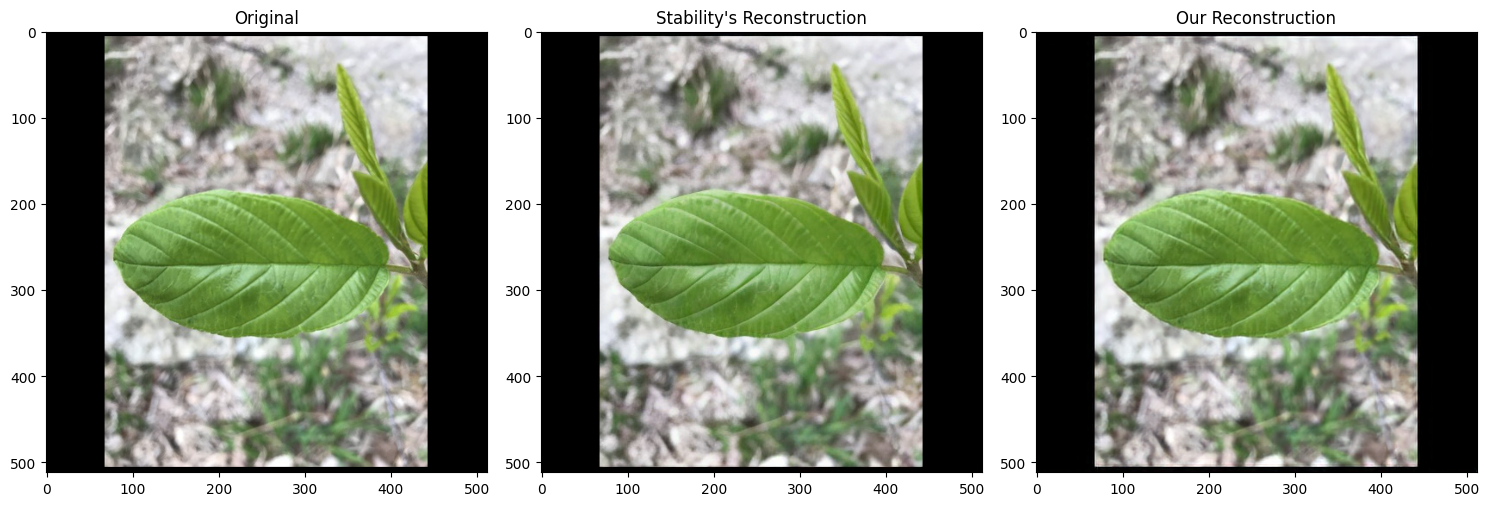

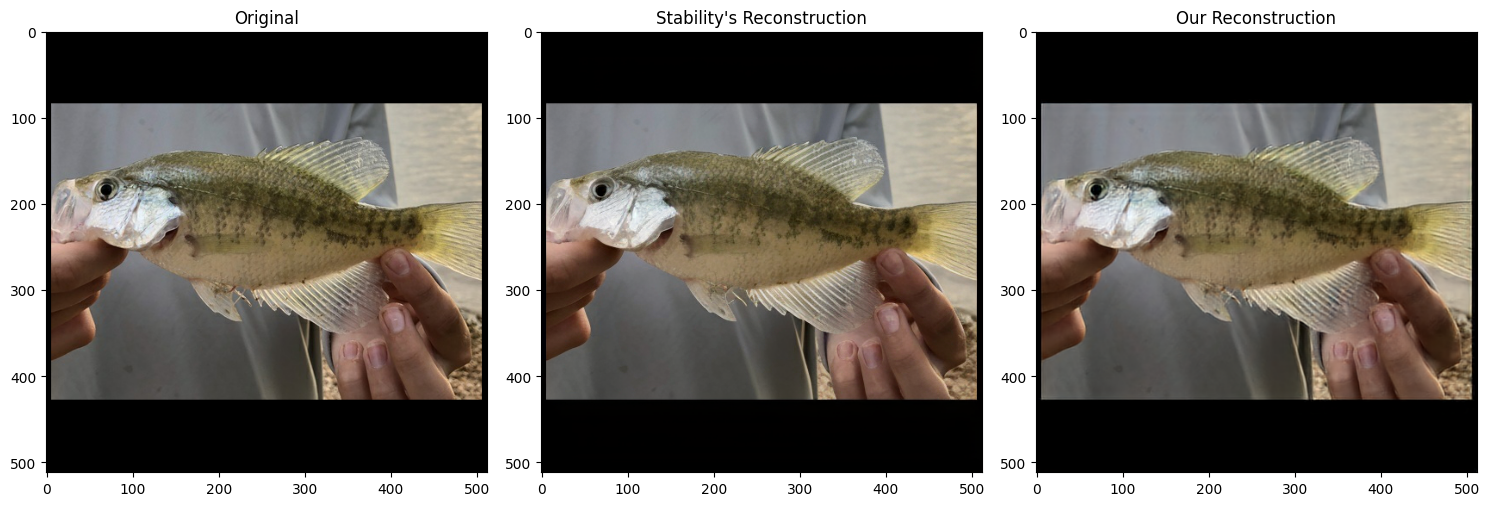

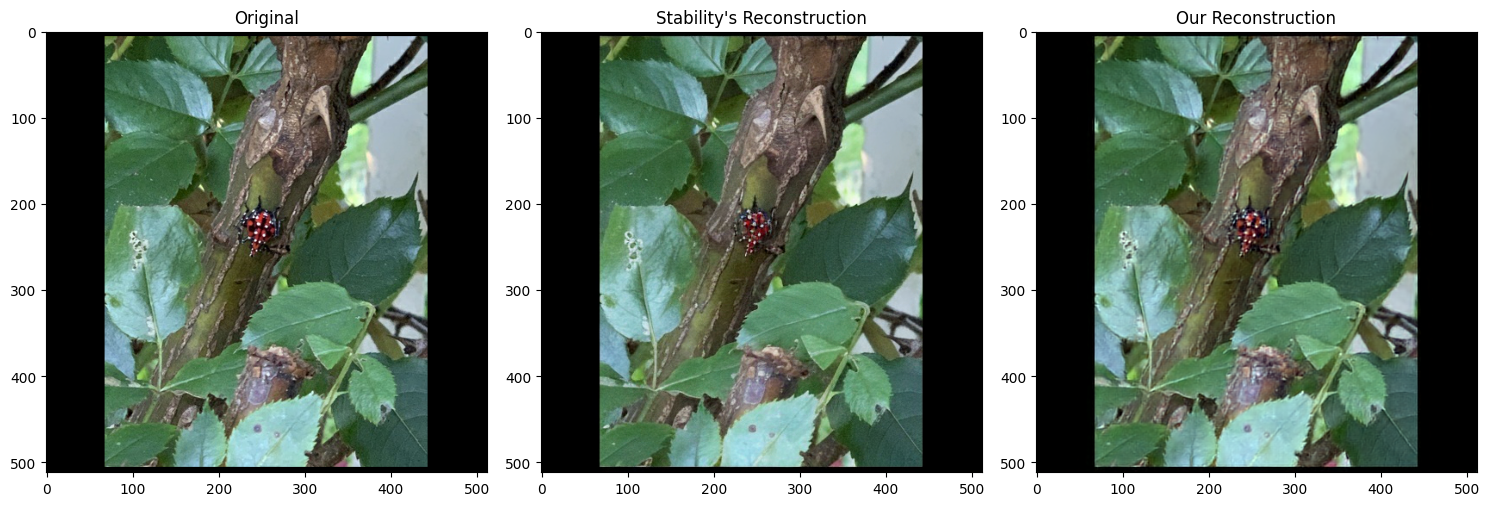

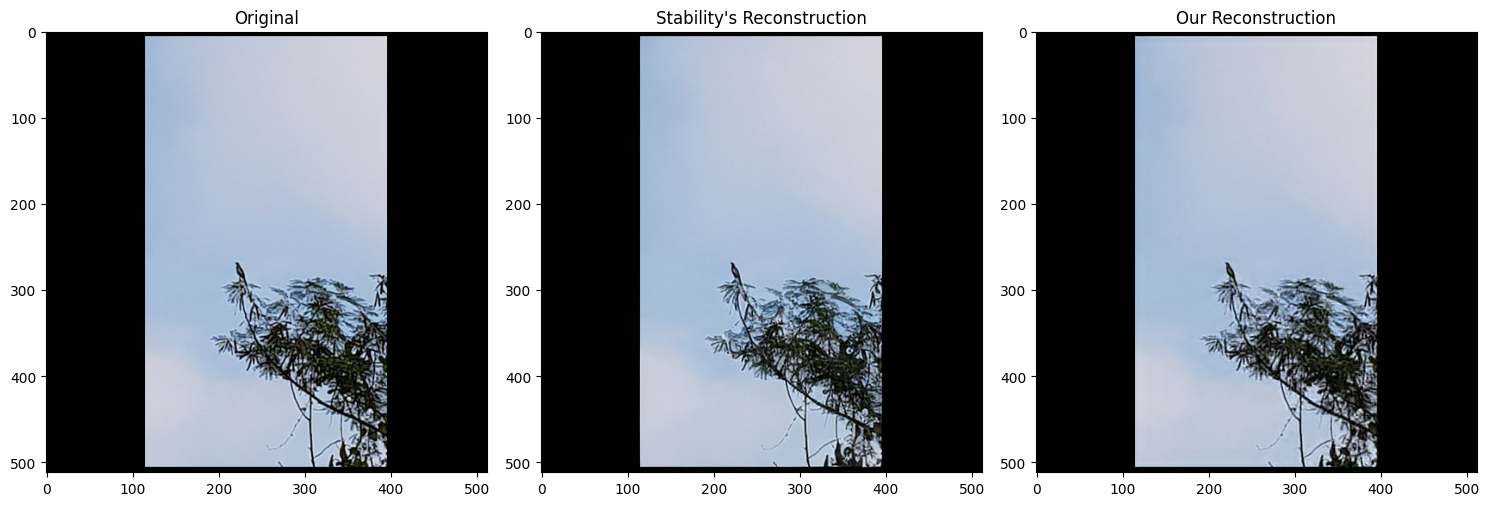

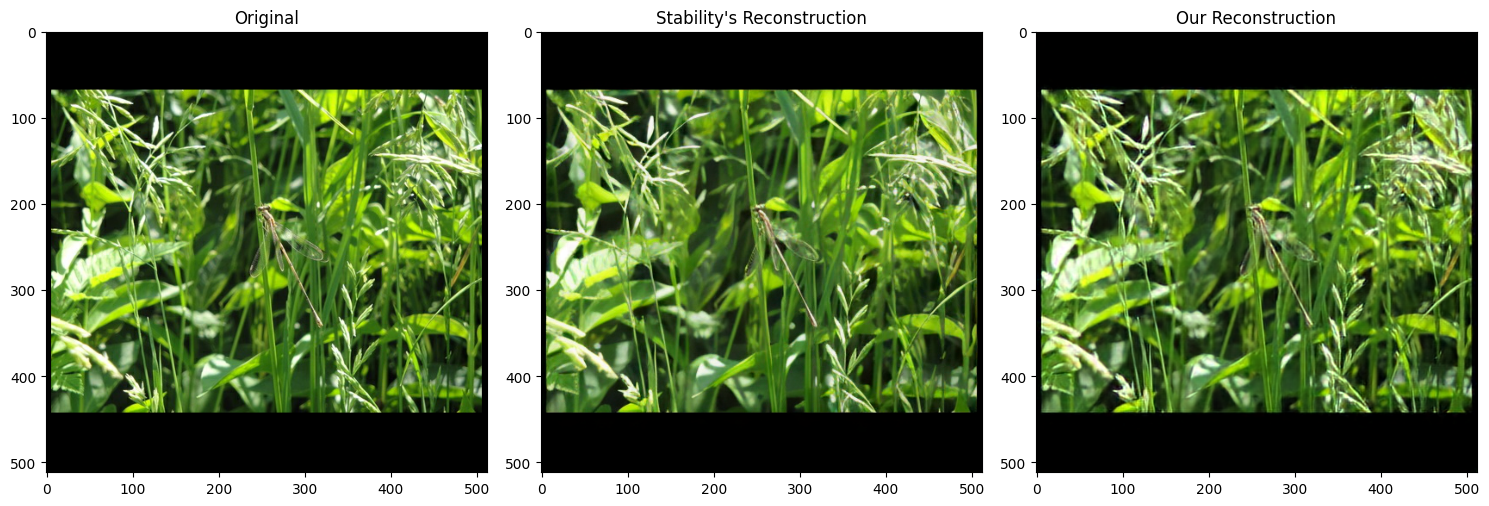

In [8]:
torch.set_grad_enabled(False)
    
postprocess = lambda x: np.clip((x.moveaxis(0, -1).cpu().detach().numpy() * 255), 0, 255).astype(int)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=7).cuda()

num_samples = 200
n_tokens = 6

stability_metrics, our_metrics = 0.0, 0.0
stability_ssim, our_ssim = 0.0, 0.0
for i, batch in enumerate(data):
    inputs, labels = batch
    inputs = inputs.cuda()
    bs, ch, height, width = inputs.shape

    our_rec = torch.clip(our_model(inputs, n_tokens), 0.0, 1.0)
    stability_rec = torch.clip(stability_model(inputs).sample, 0.0, 1.0)
    
    our_metrics += F.mse_loss(inputs, our_rec).item()
    stability_metrics += F.mse_loss(inputs, stability_rec).item()
            
    our_ssim += ssim(inputs, our_rec).item()
    stability_ssim += ssim(inputs, stability_rec).item()
        
    if i + 1 >= num_samples:
        break

print("Our MSE Loss", our_metrics / num_samples)
print("Stability's MSE Loss", stability_metrics / num_samples)

print("Our SSIM Score", our_ssim / num_samples)
print("Stability's SSIM Score", stability_ssim / num_samples)

for example_idx in [0, 1, 2, 3, 4]:
    plt.figure(figsize=(15, 7), tight_layout=True)
    plt.subplot(131)
    plt.title("Original")
    plt.imshow(postprocess(inputs[example_idx]))
    plt.subplot(132)
    plt.title(f"Stability's Reconstruction")
    plt.imshow(postprocess(stability_rec[example_idx]))
    plt.subplot(133)
    plt.title(f"Our Reconstruction")
    plt.imshow(postprocess(our_rec[example_idx]))